## **Projeto de Clusterização de Clientes** *(Setor de Energia Elétrica)*

In [1]:
# Importando as bibliotecas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pylab
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import cdist, pdist
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

# Definindo as opções do pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
df_original = pd.read_csv('Dados/consumo_energia.txt', delimiter = ';')

In [3]:
df_original.shape

(2075259, 9)

In [4]:
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    object 
 3   Global_reactive_power  object 
 4   Voltage                object 
 5   Global_intensity       object 
 6   Sub_metering_1         object 
 7   Sub_metering_2         object 
 8   Sub_metering_3         float64
dtypes: float64(1), object(8)
memory usage: 142.5+ MB


In [5]:
df_original.isnull().values.any()

True

In [6]:
df_original.isnull().sum()

Date                         0
Time                         0
Global_active_power          0
Global_reactive_power        0
Voltage                      0
Global_intensity             0
Sub_metering_1               0
Sub_metering_2               0
Sub_metering_3           25979
dtype: int64

In [7]:
display(df_original.duplicated().sum())

0

In [8]:
# Removendo os valores NA e as colunas desnecessárias (cols 1 e 2)
df_original = df_original.iloc[0:, 2:9].dropna()

In [9]:
df_original.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,3.666,0.528,235.680,15.800,0.000,1.000,17.0


<font color='Khaki'> **Obs:** O Dataset é um pouco grande, para não precisarmos reparti-lo, vamos tentar trabalhar com um formato mais leve. *(CSV -> Parquet)* </font>

In [11]:
#!pip install pyarrow
#!pip install fastparquet

In [10]:
# Convertendo as colunas para os tipos de dados adequados
df_original['Voltage'] = df_original['Voltage'].astype(dtype = 'float64')
df_original['Global_active_power'] = df_original['Global_active_power'].astype(dtype = 'float64')
df_original['Global_reactive_power'] = df_original['Global_reactive_power'].astype(dtype = 'float64')
df_original['Global_intensity'] = df_original['Global_intensity'].astype(dtype = 'float64')
df_original['Sub_metering_1'] = df_original['Sub_metering_1'].astype(dtype = 'float64')
df_original['Sub_metering_2'] = df_original['Sub_metering_2'].astype(dtype = 'float64')
df_original['Sub_metering_3'] = df_original['Sub_metering_3'].astype(dtype = 'float64')

# Salvando o DataFrame em formato Parquet
df_original.to_parquet('Dados/consumo_energia.parquet', index=False)

# Carregando o DataFrame a partir do arquivo Parquet
df = pd.read_parquet('Dados/consumo_energia.parquet')

# Verificando se os dados foram carregados corretamente
display(df.head())

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2049280 entries, 0 to 2049279
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
dtypes: float64(7)
memory usage: 109.4 MB


In [12]:
df.isnull().values.any()

False

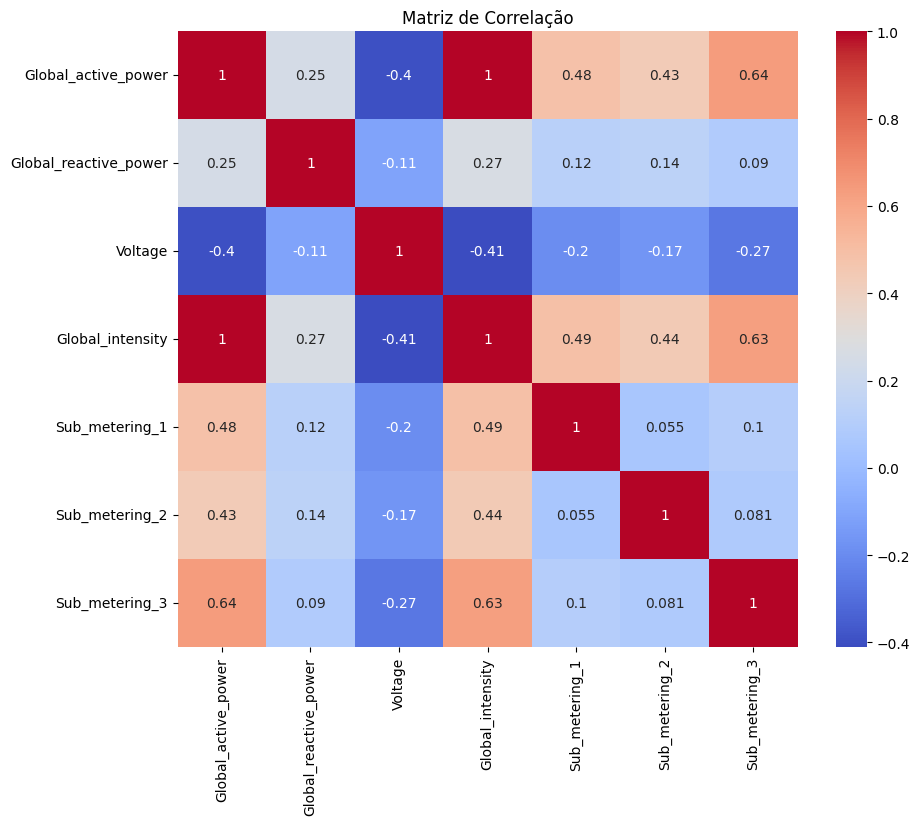

In [13]:
# Identificar correlações entre as variáveis
correlation_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Matriz de Correlação')
plt.show()

---
---

## <font color='gold'>Clusterização com **KMeans**</font>

In [14]:
# Obténdo os valores dos atributos.
df_val = df.values

In [15]:
df_val

array([[  4.216,   0.418, 234.84 , ...,   0.   ,   1.   ,  17.   ],
       [  5.36 ,   0.436, 233.63 , ...,   0.   ,   1.   ,  16.   ],
       [  5.374,   0.498, 233.29 , ...,   0.   ,   2.   ,  17.   ],
       ...,
       [  0.938,   0.   , 239.82 , ...,   0.   ,   0.   ,   0.   ],
       [  0.934,   0.   , 239.7  , ...,   0.   ,   0.   ,   0.   ],
       [  0.932,   0.   , 239.55 , ...,   0.   ,   0.   ,   0.   ]])

In [16]:
# Coletando uma amostra de 2% dos dados para aplicar o K-Means sem pesar muito
amostra1, amostra2 = train_test_split(df_val, train_size = .02)

In [17]:
amostra1.shape

(40985, 7)

In [18]:
# Aplicando redução de dimensionalidade de 7 var para 2 var utilizando Algebra Linear
pca = PCA(n_components = 2).fit_transform(amostra1)

# Determinando um range de K
k_range = range(1,12)

# Criando uma lista com os modelos K-Means treinados para cada valor de K
k_means_var = [KMeans(n_clusters = k).fit(pca) for k in k_range]

# Criando uma lista com os centros cada modelo
centroids = [X.cluster_centers_ for X in k_means_var]

# Calculando a distância euclidiana de cada ponto de dado para o centróide
k_euclid = [cdist(pca, cent, 'euclidean') for cent in centroids]
dist = [np.min(ke, axis = 1) for ke in k_euclid]

# Criando uma lista contendo a soma dos quadrados das distâncias intra-cluster 
# para cada modelo KMeans treinado.
soma_quadrados_intra_cluster = [sum(d**2) for d in dist]

# Soma total dos quadrados. Valores menores indicam que os pontos dentro de 
# cada cluster estão mais próximos entre si
soma_total = sum(pdist(pca)**2)/pca.shape[0]

# Soma dos quadrados entre clusters. 
# Entendendo dispersão dos clusters em relação à dispersão total dos dados.
# Valores menores indicam que os pontos dentro de cada cluster são mais distantes.
soma_quadrados_inter_cluster = soma_total - soma_quadrados_intra_cluster

Text(0.5, 1.0, 'Variância Explicada x Valor de K')

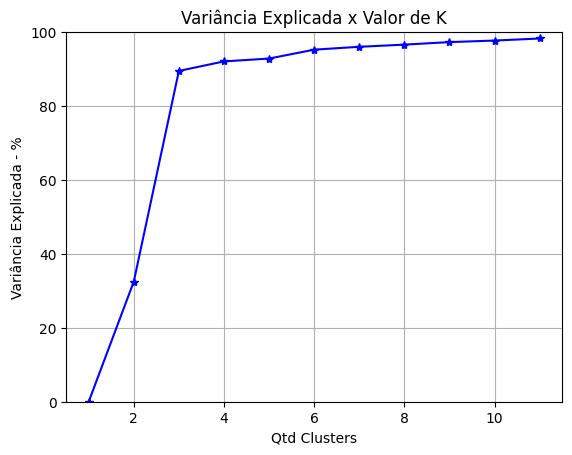

In [19]:
# Curva de Elbow
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(k_range, soma_quadrados_inter_cluster/soma_total * 100, 'b*-')
ax.set_ylim((0,100))
plt.grid(True)
plt.xlabel('Qtd Clusters')
plt.ylabel('Variância Explicada - %')
plt.title('Variância Explicada x Valor de K')

In [20]:
# Criando um modelo com K = 7
modelo_v1 = KMeans(n_clusters = 7)
modelo_v1.fit(pca)

KMeans(n_clusters=7)

In [21]:
# Obtém os valores mínimos e máximos e organiza o shape
x_min, x_max = pca[:, 0].min() - 5, pca[:, 0].max() - 1
y_min, y_max = pca[:, 1].min() + 1, pca[:, 1].max() + 5
xx, yy = np.meshgrid(np.arange(x_min, x_max, .02), np.arange(y_min, y_max, .02))
Z = modelo_v1.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

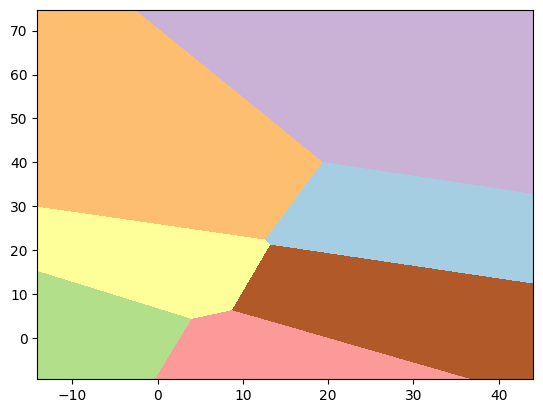

In [22]:
# Plot das áreas dos clusters
plt.figure(1)
plt.clf()
plt.imshow(Z, 
           interpolation = 'nearest',
           extent = (xx.min(), xx.max(), yy.min(), yy.max()),
           cmap = plt.cm.Paired,
           aspect = 'auto', 
           origin = 'lower')

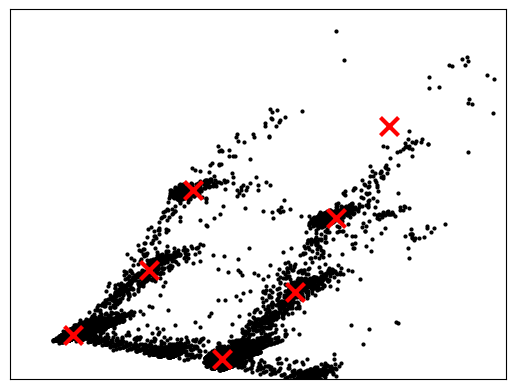

In [23]:
# Plot dos centróides
plt.plot(pca[:, 0], pca[:, 1], 'k.', markersize = 4)
centroids = modelo_v1.cluster_centers_
inert = modelo_v1.inertia_
plt.scatter(centroids[:, 0], centroids[:, 1], marker = 'x', s = 169, linewidths = 3, color = 'r', zorder = 8)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

In [24]:
# Utilizando Silhouette Score para calcular o escore de silhueta para avaliar
# a qualidade dos clusters produzidos pelo modelo KMeans treinado.
labels = modelo_v1.labels_
silhouette_score(pca, labels, metric = 'euclidean')

0.8617262776483926

<font color='Khaki'>Resultado obtido com o modelo_v1 com **K=7**: 0.86172</font>

---

In [25]:
# Criando um modelo com K = 9
modelo_v2 = KMeans(n_clusters = 9)
modelo_v2.fit(pca)

KMeans(n_clusters=9)

In [26]:
x_min, x_max = pca[:, 0].min() - 5, pca[:, 0].max() - 1
y_min, y_max = pca[:, 1].min() + 1, pca[:, 1].max() + 5
xx, yy = np.meshgrid(np.arange(x_min, x_max, .02), np.arange(y_min, y_max, .02))
Z = modelo_v2.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

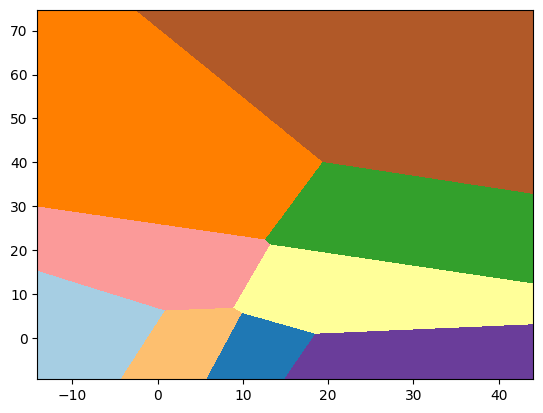

In [27]:
plt.figure(1)
plt.clf()
plt.imshow(Z, 
           interpolation = 'nearest',
           extent = (xx.min(), xx.max(), yy.min(), yy.max()),
           cmap = plt.cm.Paired,
           aspect = 'auto', 
           origin = 'lower')

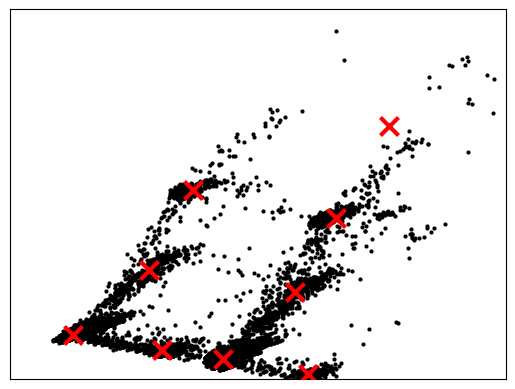

In [28]:
plt.plot(pca[:, 0], pca[:, 1], 'k.', markersize = 4)
centroids = modelo_v2.cluster_centers_
inert = modelo_v2.inertia_
plt.scatter(centroids[:, 0], centroids[:, 1], marker = 'x', s = 169, linewidths = 3, color = 'r', zorder = 8)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

In [29]:
labels = modelo_v2.labels_
silhouette_score(pca, labels, metric = 'euclidean')

0.8087643953544675

<font color='Khaki'>Resultado obtido com o modelo_v2 com **K=9**: 0.80876</font>

---

In [30]:
modelo_v3 = KMeans(n_clusters = 6)
modelo_v3.fit(pca)

KMeans(n_clusters=6)

In [31]:
x_min, x_max = pca[:, 0].min() - 5, pca[:, 0].max() - 1
y_min, y_max = pca[:, 1].min() + 1, pca[:, 1].max() + 5
xx, yy = np.meshgrid(np.arange(x_min, x_max, .02), np.arange(y_min, y_max, .02))
Z = modelo_v3.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

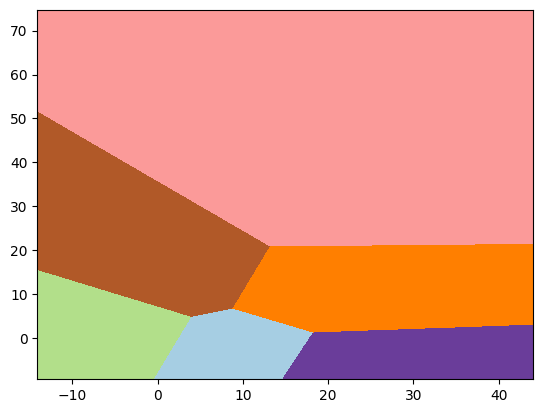

In [33]:
plt.figure(1)
plt.clf()
plt.imshow(Z, 
           interpolation = 'nearest',
           extent = (xx.min(), xx.max(), yy.min(), yy.max()),
           cmap = plt.cm.Paired,
           aspect = 'auto', 
           origin = 'lower')

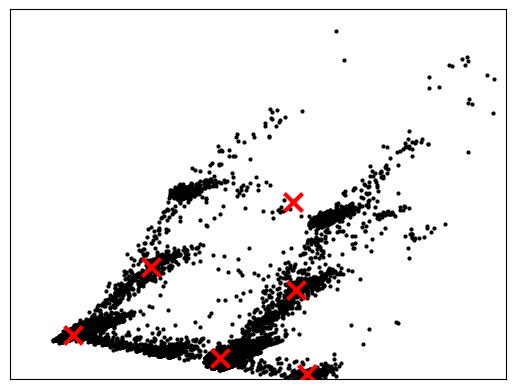

In [34]:
plt.plot(pca[:, 0], pca[:, 1], 'k.', markersize = 4)
centroids = modelo_v3.cluster_centers_
inert = modelo_v3.inertia_
plt.scatter(centroids[:, 0], centroids[:, 1], marker = 'x', s = 169, linewidths = 3, color = 'r', zorder = 8)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

In [35]:
labels = modelo_v3.labels_
silhouette_score(pca, labels, metric = 'euclidean')

0.8380044143347933

<font color='Khaki'>Resultado obtido com o modelo_v3 com **K=6**: 0.83800</font>

---

In [36]:
modelo_v4 = KMeans(n_clusters = 5)
modelo_v4.fit(pca)

KMeans(n_clusters=5)

In [37]:
labels = modelo_v4.labels_
silhouette_score(pca, labels, metric = 'euclidean')

0.7322773427162191

<font color='Khaki'>Resultado obtido com o modelo_v4 com **K=5**: 0.73227</font>

---

In [38]:
modelo_v5 = KMeans(n_clusters = 4)
modelo_v5.fit(pca)

KMeans(n_clusters=4)

In [39]:
labels = modelo_v5.labels_
silhouette_score(pca, labels, metric = 'euclidean')

0.8578440511109866

<font color='Khaki'>Resultado obtido com o modelo_v5 com **K=4**: 0.85784</font>

---

#### **Resumo dos modelos Kmeans (Escore de silhueta):** 

No **modelo_v1** com k=7: **0.86172**  
No **modelo_v2** com k=9: **0.80876**  
No **modelo_v3** com k=6: **0.83800**  
No **modelo_v4** com k=5: **0.73227**  
No **modelo_v5** com k=4: **0.85784**  

Dentre os modelos testados, o que obteve o maior escore de silhueta foi o **modelo_v1**, que com **k=7** (7 cluters) conseguiu um escore de aproximadamente **0.86172**, que é mais alto do que os outros modelos testados. Isso sugere que um modelo com esse número de clusters pode ser o mais apropriado para explicar as características desse conjunto de dados.

---

<font color='Khaki'>Analisando o modelo_v1 com k=7 (7 clusters) que obteve o melhor escore de silhueta.</font>

In [40]:
# Definindo os nomes das colunas
names = ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']

In [41]:
# Criando um DataFrame com os dados da amostra (cluster map)
cluster_map = pd.DataFrame(amostra1, columns = names)
cluster_map['Global_active_power'] = pd.to_numeric(cluster_map['Global_active_power'])
cluster_map['cluster'] = modelo_v1.labels_

In [42]:
cluster_map.head(10)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,cluster
0,4.088,0.106,239.54,17.0,0.0,0.0,18.0,2
1,1.178,0.000,238.28,5.6,0.0,0.0,1.0,1
2,1.356,0.086,241.86,5.6,0.0,1.0,18.0,2
3,0.114,0.000,240.39,0.4,0.0,0.0,0.0,1
4,0.332,0.090,242.68,1.4,0.0,0.0,1.0,1
5,1.788,0.082,240.01,7.4,0.0,0.0,18.0,2
6,4.102,0.060,240.75,17.0,38.0,0.0,17.0,0
7,1.026,0.442,239.00,4.6,0.0,1.0,12.0,2
8,0.934,0.214,238.50,4.2,0.0,3.0,9.0,1
9,0.346,0.000,247.15,1.4,0.0,0.0,1.0,1


In [43]:
cluster_map.tail(10)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,cluster
40975,0.214,0.000,242.25,0.8,0.0,0.0,0.0,1
40976,0.576,0.066,243.67,2.4,0.0,0.0,1.0,1
40977,2.654,0.234,239.56,11.0,0.0,37.0,0.0,5
40978,0.210,0.054,245.88,0.8,0.0,0.0,0.0,1
40979,2.508,0.348,239.85,10.8,0.0,26.0,11.0,6
40980,0.544,0.110,244.61,2.2,0.0,0.0,1.0,1
40981,0.450,0.202,243.97,2.0,0.0,0.0,1.0,1
40982,1.454,0.092,247.90,5.8,0.0,0.0,20.0,2
40983,2.894,0.184,240.80,12.0,0.0,1.0,18.0,2
40984,0.326,0.096,242.03,1.4,0.0,0.0,0.0,1


In [44]:
# Calculando o agrupamento
cluster_map.groupby('cluster')['Global_active_power'].mean()

cluster
0    4.411337
1    0.513185
2    1.797973
3    3.359686
4    6.478912
5    2.644032
6    3.819322
Name: Global_active_power, dtype: float64

In [45]:
# Qtd de observações por cluster
cluster_map.groupby('cluster')['Global_active_power'].count()

cluster
0      664
1    25842
2    12963
3      363
4       68
5      439
6      646
Name: Global_active_power, dtype: int64

<font color='Khaki'>Analisando o modelo_v5 com k=4 (4 clusters) que obteve o segundo melhor escore de silhueta.</font>

In [47]:
cluster_map = pd.DataFrame(amostra1, columns = names)
cluster_map['Global_active_power'] = pd.to_numeric(cluster_map['Global_active_power'])
cluster_map['cluster'] = modelo_v5.labels_

In [48]:
cluster_map.groupby('cluster')['Global_active_power'].mean()

cluster
0    0.519405
1    1.818700
2    3.208774
3    4.373321
Name: Global_active_power, dtype: float64

In [49]:
cluster_map.groupby('cluster')['Global_active_power'].count()

cluster
0    25958
1    13151
2      703
3     1173
Name: Global_active_power, dtype: int64

Ao analisar o modelo com um número menor de clusters, pode-se observar que realmente existe uma tendência da concentração de determinadas características que em elementos que estão agrupados em 2 grandes grupos.  
Dependendo do problema a ser tratado e das características dos dados a serem agrupadas, deve-se ajustar os hiperparâmetros para que características relevantes não sejam subestimadas pelo modelo.  


<font color='Khaki'>**Modelo_v6 reproduzindo o modelo_v1 com k=7 (7 clusters) utilizando dados normalizados.**</font>

In [50]:
# Extraindo os valores do DataFrame
df_val = df.values

# Padronizando os valores utilizando MinMaxScaler
Padronizador = MinMaxScaler()
df_val = Padronizador.fit_transform(df_val)

# Dividindo os dados em conjunto de treinamento e teste
amostra3, amostra4 = train_test_split(df_val, train_size=.02)

# Realizando a redução de dimensionalidade usando PCA
pca = PCA(n_components=2).fit_transform(amostra3)

# Definindo uma faixa de valores para o número de clusters
k_range = range(1, 12)

# Treinando modelos KMeans com diferentes números de clusters
k_means_var = [KMeans(n_clusters=k).fit(pca) for k in k_range]

# Obtendo os centróides de cada cluster
centroids = [X.cluster_centers_ for X in k_means_var]

# Calculando as distâncias dos pontos aos centróides
k_euclid = [cdist(pca, cent, 'euclidean') for cent in centroids]

# Calculando as menores distâncias de cada ponto ao seu centróide
dist = [np.min(ke, axis=1) for ke in k_euclid]

# Calculando a soma dos quadrados das distâncias intra-cluster
soma_quadrados_intra_cluster = [sum(d**2) for d in dist]

# Calculando a soma total dos quadrados das distâncias
soma_total = sum(pdist(pca)**2) / pca.shape[0]

# Calculando a soma dos quadrados das distâncias inter-cluster
soma_quadrados_inter_cluster = soma_total - soma_quadrados_intra_cluster

# Treinando o modelo KMeans final com o número ideal de clusters
modelo_v6 = KMeans(n_clusters=7)
modelo_v6.fit(pca)

# Definindo a grade para a visualização da superfície de decisão
x_min, x_max = pca[:, 0].min() - 5, pca[:, 0].max() - 1
y_min, y_max = pca[:, 1].min() + 1, pca[:, 1].max() + 5
xx, yy = np.meshgrid(np.arange(x_min, x_max, .02), np.arange(y_min, y_max, .02))

# Prevêndo os clusters para cada ponto na grade
Z = modelo_v6.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Obténdo os rótulos de cluster do modelo
labels = modelo_v6.labels_

# Calculando o escore de silhueta para avaliar a qualidade dos clusters
silhouette_score(pca, labels, metric='euclidean')

# Definindo os nomes das colunas do DataFrame original
names = ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']

# Criando um DataFrame para mapear os pontos originais aos clusters
cluster_map = pd.DataFrame(amostra3, columns=names)
cluster_map['Global_active_power'] = pd.to_numeric(cluster_map['Global_active_power'])
cluster_map['cluster'] = modelo_v6.labels_

In [51]:
cluster_map.head(10)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,cluster
0,0.007424,0.000000,0.557997,0.008299,0.0,0.0000,0.032258,2
1,0.139598,0.382734,0.513086,0.141079,0.0,0.0125,0.580645,1
2,0.125294,0.043165,0.654281,0.120332,0.0,0.0000,0.000000,4
3,0.012855,0.000000,0.643942,0.012448,0.0,0.0000,0.000000,2
4,0.165309,0.174101,0.791276,0.153527,0.0,0.0500,0.612903,5
5,0.014123,0.105036,0.667205,0.016598,0.0,0.0000,0.032258,2
6,0.031686,0.145324,0.640065,0.037344,0.0,0.0125,0.000000,2
7,0.013036,0.000000,0.539903,0.016598,0.0,0.0000,0.000000,2
8,0.025349,0.041727,0.516963,0.029046,0.0,0.0000,0.000000,2
9,0.119862,0.000000,0.665913,0.112033,0.0,0.0000,0.612903,5


In [52]:
cluster_map.tail(10)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,cluster
40975,0.014304,0.090647,0.458805,0.016598,0.000000,0.0000,0.032258,4
40976,0.161687,0.086331,0.523748,0.157676,0.000000,0.0000,0.548387,5
40977,0.114974,0.000000,0.681422,0.107884,0.000000,0.0000,0.612903,5
40978,0.171103,0.283453,0.537641,0.170124,0.000000,0.0250,0.580645,1
40979,0.015390,0.040288,0.572859,0.016598,0.000000,0.0000,0.032258,2
40980,0.120587,0.000000,0.232956,0.141079,0.000000,0.2625,0.000000,0
40981,0.019192,0.000000,0.693700,0.024896,0.000000,0.0000,0.000000,2
40982,0.021003,0.153957,0.560582,0.024896,0.000000,0.0000,0.032258,2
40983,0.203694,0.145324,0.485945,0.199170,0.011364,0.0000,0.580645,1
40984,0.182872,0.064748,0.321163,0.186722,0.000000,0.0000,0.354839,1


### <font color='Khaki'>Resultado da clusterização utilizando ***KMeans***</font>

In [53]:
# Verificando o número de clusters
cluster_map.groupby('cluster')['Global_active_power'].count()

cluster
0     1170
1     4048
2    17279
3      322
4     8442
5     8375
6     1349
Name: Global_active_power, dtype: int64

---
---

## <font color='gold'>Clusterização com **AgglomerativeClustering**</font>

In [55]:
from sklearn.cluster import AgglomerativeClustering

In [56]:
# Treinando o modelo AgglomerativeClustering com 7 clusters
modelo_agglomerative = AgglomerativeClustering(n_clusters=7)
labels_agglomerative = modelo_agglomerative.fit_predict(pca)

# Calculando o escore de silhueta para avaliar a qualidade dos clusters
silhouette_score(pca, labels_agglomerative, metric='euclidean')

# Criando um DataFrame para mapear os pontos originais aos clusters
cluster_map_agglomerative = pd.DataFrame(amostra3, columns=names)
cluster_map_agglomerative['Global_active_power'] = pd.to_numeric(cluster_map_agglomerative['Global_active_power'])
cluster_map_agglomerative['cluster'] = labels_agglomerative

# Contando o número de pontos em cada cluster
cluster_counts_agglomerative = cluster_map_agglomerative.groupby('cluster')['Global_active_power'].count()


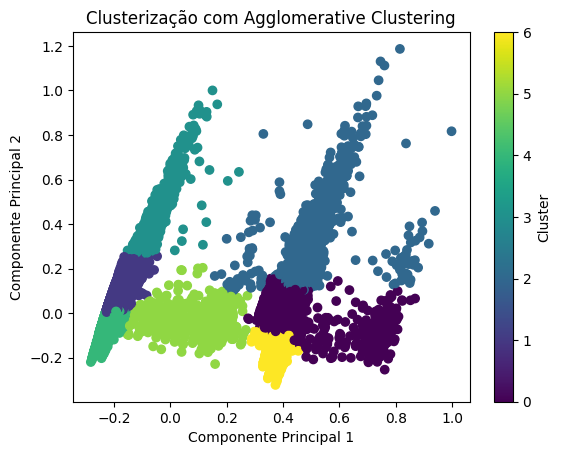

In [57]:
# Plotagem do gráfico de dispersão com os pontos coloridos por cluster
plt.scatter(pca[:, 0], pca[:, 1], c=labels_agglomerative, cmap='viridis')
plt.title('Clusterização com Agglomerative Clustering')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.colorbar(label='Cluster')
plt.show()

### <font color='Khaki'>Resultado da clusterização utilizando ***AgglomerativeClustering***</font>

In [58]:
print(cluster_counts_agglomerative)

cluster
0     6689
1    10054
2     1818
3      905
4    15698
5      956
6     4865
Name: Global_active_power, dtype: int64


---
---

## <font color='gold'>Clusterização com **DBSCAN** - (Density-Based Spatial Clustering of Applications with Noise)</font>

In [59]:
from sklearn.cluster import DBSCAN

In [109]:
# Criando o modelo DBSCAN
modelo_dbscan = DBSCAN(eps=0.03, min_samples=20, n_jobs=-1)

# Obtendo os rótulos dos clusters
labels_dbscan = modelo_dbscan.fit_predict(pca)

# Visualizando os rótulos dos clusters gerados
print(labels_dbscan)

# Visualizando o número de clusters (-1 representa pontos considerados como ruído)
print("Número de clusters:", len(set(labels_dbscan)) - (1 if -1 in labels_dbscan else 0))

[ 0  1  0 ...  0  1 -1]
Número de clusters: 5


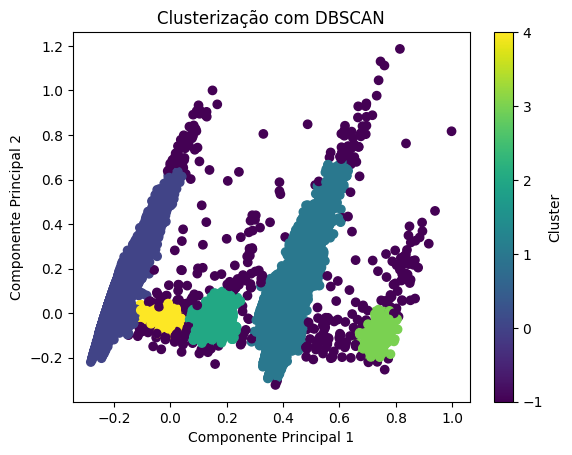

In [112]:
# Plotando o gráfico de dispersão com os pontos coloridos por cluster
plt.scatter(pca[:, 0], pca[:, 1], c=labels_dbscan, cmap='viridis')
plt.title('Clusterização com DBSCAN')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.colorbar(label='Cluster')
plt.show()

### <font color='Khaki'>Resultado da clusterização utilizando ***DBSCAN*** </font>

In [110]:
# Visualizando a contagem de pontos em cada cluster
unique, counts = np.unique(labels_dbscan, return_counts=True)
print(dict(zip(unique, counts)))

{-1: 435, 0: 26610, 1: 12840, 2: 709, 3: 267, 4: 124}


---
---

## <font color='gold'>Clusterização com o algoritmo  **Gaussian Mixture Model (GMM)**</font>

In [120]:
from sklearn.mixture import GaussianMixture

In [121]:
# Padronizando os dados
Padronizador = StandardScaler()
df_val_padronizado = Padronizador.fit_transform(df_val)

In [123]:
# Criando o modelo GMM
modelo_gmm = GaussianMixture(n_components=7, random_state=42)

In [124]:
# Treinando o modelo GMM
modelo_gmm.fit(df_val_padronizado)

GaussianMixture(n_components=7, random_state=42)

In [125]:
# Prevendo os rótulos dos clusters
rotulos_gmm = modelo_gmm.predict(df_val_padronizado)

# Adicionando os rótulos dos clusters ao DataFrame original
df_clusterizado = pd.DataFrame(df_val, columns=names)
df_clusterizado['cluster'] = rotulos_gmm

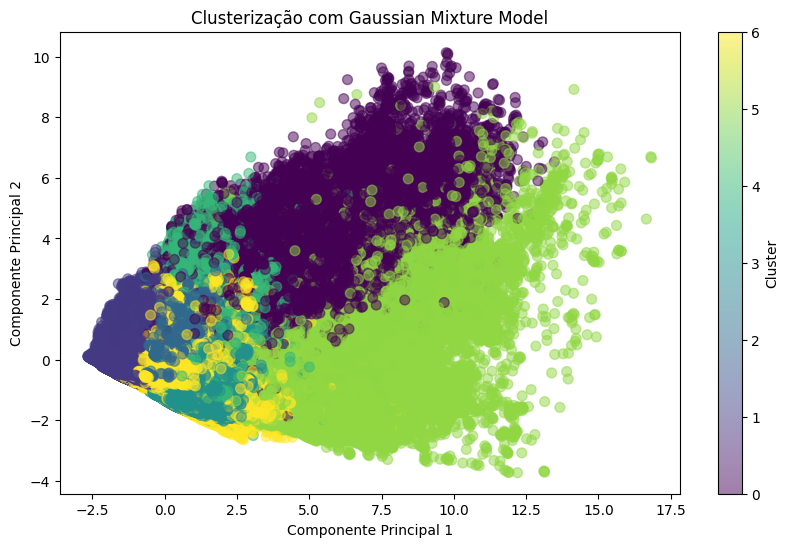

In [126]:
# Plotando os pontos coloridos de acordo com os clusters atribuídos pelo GMM
plt.figure(figsize=(10, 6))
plt.scatter(pca[:, 0], pca[:, 1], c=rotulos_gmm, cmap='viridis', s=50, alpha=0.5)
plt.title('Clusterização com Gaussian Mixture Model')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.colorbar(label='Cluster')
plt.show()

### <font color='Khaki'>Resultado da clusterização utilizando ***Gaussian Mixture Model (GMM)*** </font>

In [127]:
# Verificando o número de pontos em cada cluster
contagem_por_cluster = df_clusterizado.groupby('cluster').size()
print(contagem_por_cluster)

cluster
0      66958
1    1063905
2      51051
3     479981
4      49264
5      65231
6     272890
dtype: int64


---
---